In [52]:
import tensorflow as tf # Tensorflow 2.3
import tensorflow_hub as hub # Tensorflow-hub 0.12
import PIL.Image as Image # Pillow 
import numpy as np # Numpy
from tqdm import tqdm # progress bar package
import tensorflow_datasets as tfds
import os
from time import process_time
from memory_profiler import memory_usage
from ipynb.fs.full.utilities import *
import tempfile
import tracemalloc
import matplotlib.image as mpimg
import pandas as pd

#se sxesi me ton xrono: default_timer == perf_counter
#perf_counter:does include time elapsed during sleep
#process_time(): does NOT include time elapsed during sleep

In [2]:
'''
task = int(input("Choose a problem domain by typing the corresponding number: \n1.Image\n2.Text\n3.Video\n4.Audio"))
if(task == 1):
    task = int(input("Choose a task by typing the corresponding number:\n1.Image Classification\n2.Image Segmentation\n3.Pose Estimation"))
    if(task == 1):
        task = int(input("Choose a model by typing the corresponding number:\n1.MobileNet V2\n2.ResNet50 V1\n3.Inception V3\n4.NASNet-A large\n5.EfficientNet V2 M"))

dataset = input('Absolute path to the dataset')
values = input('Absolute path to the text file of the groundtruth')
'''

batch = int(input("Insert batch size"))
if batch == 1:
    batch = None

## Image Classification

In [3]:
#Groundtruth
val_groundtruth = load_values('Datasets/ImageNet/val.txt')

### MobileNetV2

In [5]:
# Load Model
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", output_shape=[1001])
])
model.build([batch,224,224,3]) # Batch input shape
image_shape = (224,224)

In [7]:
# Inference and metrics

t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
duration = 0
data = np.zeros((batch , 224, 224, 3))
tracemalloc.start()

for file in os.listdir('Datasets/ImageNet')[:1000]:
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum%batch,:] = prepare_standard(image) # Preprocessing
    imagenum += 1

    if (imagenum%batch == 0):
        start = process_time()    
        prediction = model.predict(data,batch_size = batch)
        duration += (process_time()-start)
        data = np.zeros((batch , 224, 224, 3))
        
        for i in range(batch):
            if((val_groundtruth[imagenum - 1 - i]+1) in np.argpartition(prediction[batch - 1 -i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
                    t5+=1
                    if(val_groundtruth[imagenum - 1 - i]+1) == np.argmax(prediction[batch - 1 -i]):
                        t1+=1

start = process_time()    
prediction = model.predict(data[:(imagenum%batch)],batch_size = batch)
duration += (process_time()-start)

for i in range(imagenum - (imagenum % batch),imagenum):
    if((val_groundtruth[i]+1) in np.argpartition(prediction[i - (imagenum - (imagenum % batch))], -5)[-5:]): # argpartition σε Ο(n) για τα top5
        t5+=1
        if(val_groundtruth[i]+1) == np.argmax(prediction[i - (imagenum - (imagenum % batch))]):
            t1+=1

print('Size: 14MB')
print("Batch size: "+ str(batch))
print('Peak memory usage is: {} KiB '.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()


Size: 14MB
Batch size: 32
Peak memory usage is: 264973 KiB 
Top-1 accuracy for 1000 images is: 71.9 %
Top-5 accuracy for 1000 images is: 91.2 %
Latency is: 0.54 s
Throughput is: 1.86 samples/sec


In [9]:
# Inference and metrics

t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
duration = 0
data = np.zeros((batch , 224, 224, 3))
tracemalloc.start()

for file in tqdm(os.listdir('Datasets/ImageNet')[:-1]):
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum%batch,:] = prepare(os.path.join('Datasets/ImageNet', file),224) # Preprocessing
    imagenum += 1

    if (imagenum%batch == 0):
        start = process_time()    
        prediction = model.predict(data,batch_size = batch)
        duration += (process_time()-start)
        data = np.zeros((batch , 224, 224, 3))
        
        for i in range(batch):
            if((val_groundtruth[imagenum - 1 - i]+1) in np.argpartition(prediction[batch - 1 -i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
                    t5+=1
                    if(val_groundtruth[imagenum - 1 - i]+1) == np.argmax(prediction[batch - 1 -i]):
                        t1+=1

start = process_time()    
prediction = model.predict(data[:(imagenum%batch)],batch_size = batch)
duration += (process_time()-start)

for i in range(imagenum - (imagenum % batch),imagenum):
    if((val_groundtruth[i]+1) in np.argpartition(prediction[i - (imagenum - (imagenum % batch))], -5)[-5:]): # argpartition σε Ο(n) για τα top5
        t5+=1
        if(val_groundtruth[i]+1) == np.argmax(prediction[i - (imagenum - (imagenum % batch))]):
            t1+=1

print('Size: 14MB')
print("Batch size: "+ str(batch))
print('Peak memory usage is: {} KiB '.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()


100%|██████████| 50000/50000 [2:10:16<00:00,  6.40it/s]  


Size: 14MB
Batch size: 32
Peak memory usage is: 1823744 KiB 
Top-1 accuracy for 50000 images is: 71.8 %
Top-5 accuracy for 50000 images is: 90.4 %
Latency is: 0.41 s
Throughput is: 2.42 samples/sec


### ResNet50 V1

In [11]:
#Load the model

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/tensorflow/resnet_50/classification/1") # First input is the directory to the saved model.
])
model.build([batch, 224, 224, 3]) # Batch input shape.
image_shape = (224,224)

In [10]:
# Inference and metrics
t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
data = np.zeros((1000 , 224, 224, 3))

for file in os.listdir('Datasets/ImageNet')[:1000]:
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum,:] = prepare_standard(image) # Preprocessing
    imagenum += 1

tracemalloc.start()
start = process_time()
prediction = model.predict(data,batch_size = batch)
duration += (process_time()-start)

for i in range(imagenum):
    if((val_groundtruth[i]) in np.argpartition(prediction[i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
        t5+=1
        if(val_groundtruth[i]) == np.argmax(prediction[i]):
            t1+=1

print('Size: 98MB')
print('Peak memory usage is: {} KiB'.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum+1))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum+1))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()

Size: 98MB
Peak memory usage is: 593280 KiB
Top-1 accuracy for 1000 images is: 74.2 %
Top-5 accuracy for 1000 images is: 91.6 %
Latency is: 3.42 s
Throughput is: 0.29 samples/sec


In [14]:
# Inference and metrics

t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
duration = 0
data = np.zeros((batch , 224, 224, 3))
tracemalloc.start()

for file in tqdm(os.listdir('Datasets/ImageNet')[:1000]):
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum%batch,:] = prepare(os.path.join('Datasets/ImageNet', file),224) # Preprocessing
    imagenum += 1

    if (imagenum%batch == 0):
        start = process_time()    
        prediction = model.predict(data,batch_size = batch)
        duration += (process_time()-start)
        data = np.zeros((batch , 224, 224, 3))
        
        for i in range(batch):
            if((val_groundtruth[imagenum - 1 - i]) in np.argpartition(prediction[batch - 1 -i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
                    t5+=1
                    if(val_groundtruth[imagenum - 1 - i]) == np.argmax(prediction[batch - 1 -i]):
                        t1+=1

start = process_time()    
prediction = model.predict(data[:(imagenum%batch)],batch_size = batch)
duration += (process_time()-start)

for i in range(imagenum - (imagenum % batch),imagenum):
    if((val_groundtruth[i]) in np.argpartition(prediction[i - (imagenum - (imagenum % batch))], -5)[-5:]): # argpartition σε Ο(n) για τα top5
        t5+=1
        if(val_groundtruth[i]) == np.argmax(prediction[i - (imagenum - (imagenum % batch))]):
            t1+=1

print('Size: 98MB')
print("Batch size: "+ str(batch))
print('Peak memory usage is: {} KiB '.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()

 33%|███▎      | 328/1000 [06:12<12:43,  1.14s/it]  


KeyboardInterrupt: 

### Inception V3

In [11]:
#Load the model

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v3/classification/5") # First input is the directory to the saved model.
])
model.build([batch, 299, 299, 3]) # Batch input shape.
image_shape = (299,299)

In [12]:
# Inference and metrics
t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
duration = 0
data = np.zeros((1000 , 299, 299, 3))

for file in os.listdir('Datasets/ImageNet')[:1000]:
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum,:] = preprocessing(image, image_shape)[0] # Preprocessing
    imagenum += 1

tracemalloc.start()   
start = process_time()    
prediction = model.predict(data,batch_size = batch)
duration += (process_time()-start)

for i in range(imagenum):
    if((val_groundtruth[i]+1) in np.argpartition(prediction[i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
        t5+=1
        if(val_groundtruth[i]+1) == np.argmax(prediction[i]):
            t1+=1

print('Size: 92MB')
print('Peak memory usage is: {} KiB'.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()

Size: 92MB
Peak memory usage is: 594512 KiB
Top-1 accuracy for 1000 images is: 69.2 %
Top-5 accuracy for 1000 images is: 87.5 %
Latency is: 2.21 s
Throughput is: 0.45 samples/sec


In [ ]:
# Inference and metrics

t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
duration = 0
data = np.zeros((batch , 224, 224, 3))
tracemalloc.start()

for file in tqdm(os.listdir('Datasets/ImageNet')[:-1]):
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum%batch,:] = prepare(os.path.join('Datasets/ImageNet', file),224) # Preprocessing
    imagenum += 1

    if (imagenum%batch == 0):
        start = process_time()    
        prediction = model.predict(data,batch_size = batch)
        duration += (process_time()-start)
        data = np.zeros((batch , 224, 224, 3))
        
        for i in range(batch):
            if((val_groundtruth[imagenum - 1 - i]+1) in np.argpartition(prediction[batch - 1 -i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
                    t5+=1
                    if(val_groundtruth[imagenum - 1 - i]+1) == np.argmax(prediction[batch - 1 -i]):
                        t1+=1

start = process_time()    
prediction = model.predict(data[:(imagenum%batch)],batch_size = batch)
duration += (process_time()-start)

for i in range(imagenum - (imagenum % batch),imagenum):
    if((val_groundtruth[i]+1) in np.argpartition(prediction[i - (imagenum - (imagenum % batch))], -5)[-5:]): # argpartition σε Ο(n) για τα top5
        t5+=1
        if(val_groundtruth[i]+1) == np.argmax(prediction[i - (imagenum - (imagenum % batch))]):
            t1+=1

print('Size: 14MB')
print("Batch size: "+ str(batch))
print('Peak memory usage is: {} KiB '.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()


### NASNet-A large

In [13]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/nasnet_large/classification/5")
])
model.build([batch, 331, 331, 3])  # Batch input shape.
image_shape = (331,331)

In [14]:
# Inference and metrics
t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
duration = 0
data = np.zeros((100 , 331, 331, 3))

for file in os.listdir('Datasets/ImageNet')[:100]:
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum,:] = preprocessing(image, image_shape)[0] # Preprocessing
    imagenum += 1

tracemalloc.start()   
start = process_time()    
prediction = model.predict(data,batch_size = batch)
duration += (process_time()-start)

for i in tqdm(range(imagenum)):
    if((val_groundtruth[i]+1) in np.argpartition(prediction[i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
            t5+=1
            if(val_groundtruth[i]+1) == np.argmax(prediction[i]):
                t1+=1

print('Size: 343MB')
print('Peak memory usage is: {} KiB'.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()

100%|██████████| 100/100 [00:00<00:00, 547.45it/s]


Size: 343MB
Peak memory usage is: 135620 KiB
Top-1 accuracy for 100 images is: 79.0 %
Top-5 accuracy for 100 images is: 94.0 %
Latency is: 21.82 s
Throughput is: 0.05 samples/sec


### EfficientNetV2M

In [15]:
#Load Model
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/classification/2")
])
model.build([batch, 480, 480, 3])  # Batch input shape.
image_shape = (480,480)

In [17]:
# Inference and metrics
t1 = 0 # Variable for correct predictions
t5 = 0 # Variable for top-5 correct predictions

imagenum = 0
duration = 0
data = np.zeros((100 , 480, 480, 3))

for file in os.listdir('Datasets/ImageNet')[:100]:
    image = Image.open(os.path.join('Datasets/ImageNet', file), 'r')
    data[imagenum,:] = preprocessing(image, image_shape)[0] # Preprocessing
    imagenum += 1

tracemalloc.start()   
start = process_time()    
prediction = model.predict(data,batch_size = batch)
duration += (process_time()-start)

for i in tqdm(range(imagenum)):
    if((val_groundtruth[i]) in np.argpartition(prediction[i], -5)[-5:]): # argpartition σε Ο(n) για τα top5
            t5+=1
            if(val_groundtruth[i]) == np.argmax(prediction[i]):
                t1+=1

print('Size: 220MB')
print('Peak memory usage is: {} KiB'.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Top-1 accuracy for {} images is: {} %'.format(imagenum, round((t1/(imagenum))*100,1))) # Printing Accuracy.
print('Top-5 accuracy for {} images is: {} %'.format(imagenum, round((t5/(imagenum))*100,1))) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()

100%|██████████| 100/100 [00:00<00:00, 4833.26it/s]

Size: 220MB
Peak memory usage is: 3515714 KiB
Top-1 accuracy for 100 images is: 84.0 %
Top-5 accuracy for 100 images is: 97.0 %
Latency is: 23.45 s
Throughput is: 0.04 samples/sec


## Image Segmentation

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### UNet

In [3]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/nvidia/unet/industrial/class_1/1") # First input is the directory to the saved model.
])
model.build([batch, 512, 512, 1])
image_shape = (512,512)

In [4]:
#Label Images
with open('Datasets/DAGM2007/Class1_def/labels.txt') as f:
    labels = f.readlines()
    f.close()

for i in range(len(labels)):
    labels[i] = labels[i].strip('\n').split('\t')[1:]
    labels[i] = [float(x) for x in labels[i]]

labels = labels[:-1]

In [6]:
imagenum = 0
duration = 0
iou_score = 0
x = np.linspace(0, 512, 512)  # x values of interest
y = np.linspace(0, 512, 512)[:, None]  # y values of interest, as a "column" array

for file in tqdm(os.listdir('Datasets/DAGM2007/Class1_def')[:-1]):

    img = mpimg.imread(os.path.join('Datasets/DAGM2007/Class1_def', file), 'r')

    # Image preprocessing
    img =  np.expand_dims(img, axis=2)
    img =  np.expand_dims(img, axis=0)
    img = (img-0.5)/0.5

    #data[imagenum,:] = img
    #labelimg[imagenum,:] = calc_ellipse(x, y, label[imagenum])
    start = process_time()
    prediction = model.predict(img)
    duration += (process_time()-start)
    labelimg = calc_ellipse(x, y, labels[int(file[:-4])-1])
    iou_score += iou_calc(labelimg, prediction)
    imagenum += 1
    
#prediction = model.predict(data,batch_size = 1)

print('Average IoU is %s' % (iou_score/imagenum)) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.

#print(np.shape(prediction))
#plt.figure(figsize = (10,10))
#plt.imshow(np.squeeze(prediction), cmap='gray')

100%|██████████| 150/150 [07:51<00:00,  3.14s/it]

Average IoU is 0.8923617727825628
Latency is: 13.3 s
Throughput is: 0.08 samples/sec


In [5]:
imagenum = 0
duration = 0
iou_score = 0

x = np.linspace(0, 512, 512)  # x values of interest
y = np.linspace(0, 512, 512)[:, None]  # y values of interest, as a "column" array

data = np.zeros((batch , 512, 512))
labelimg = np.zeros((batch , 512, 512))
tracemalloc.start()

for file in tqdm(os.listdir('Datasets/DAGM2007/Class1_def')[:-1]):

    img = mpimg.imread(os.path.join('Datasets/DAGM2007/Class1_def', file), 'r')

    # Image preprocessing
    img =  np.expand_dims(img, axis=2)
    img =  np.expand_dims(img, axis=0)
    img = (img-0.5)/0.5

    data[imagenum%batch] = np.squeeze(img)
    labelimg[imagenum%batch] = calc_ellipse(x, y, labels[int(file[:-4])-1])
    imagenum += 1

    if (imagenum%batch == 0):

        start = process_time()
        prediction = model.predict(data, batch_size = batch)
        duration += (process_time()-start)

        for i in range(batch):  

            iou_score += iou_calc(labelimg[i], prediction[i])

        data = np.zeros((batch , 512, 512))
        labelimg = np.zeros((batch , 512, 512))

start = process_time()    
prediction = model.predict(data[:(imagenum%batch)],batch_size = batch)
duration += (process_time()-start)

for i in range(imagenum%batch):
    
    iou_score += iou_calc(labelimg[i], prediction[i])
    
print('Size: 7MB(?)')
print("Batch size: "+ str(batch))
print('Peak memory usage is: {} KiB '.format(round(((tracemalloc.get_traced_memory()[1])/1024))))
print('Average IoU is %s' % (iou_score/imagenum)) # Printing Accuracy.
print('Latency is: {} s'.format(round(duration/(imagenum),2))) # Printing Latency.
print('Throughput is: {} samples/sec'.format(round((imagenum)/duration,2))) # Printing Throughput.
tracemalloc.stop()

#print(np.shape(prediction))
#plt.figure(figsize = (10,10))
#plt.imshow(np.squeeze(prediction), cmap='gray')

100%|██████████| 150/150 [11:58<00:00,  4.79s/it] 


Size: 7MB(?)
Batch size: 16
Peak memory usage is: 216422 KiB 
Average IoU is 0.8923617727825628
Latency is: 17.65 s
Throughput is: 0.06 samples/sec


### deeplabv3-mobilenetv2-ade20k

In [53]:
# Load the model.
interpreter = tf.lite.Interpreter(model_path="Models/lite-model_deeplabv3-mobilenetv2-ade20k_1_default_2.tflite")

#ImagePreprocessing
image_for_prediction = prepare('Datasets/ADE20K_2021_17_01/images/ADE/validation/cultural/apse__indoor/ADE_val_00000025.jpg',513)
image_for_prediction = np.asarray(image_for_prediction).astype(np.float32)

image_for_prediction = np.expand_dims(image_for_prediction, 0)

# Set model input.
input_details = interpreter.get_input_details()
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]
print(input_size)

# Invoke the interpreter to run inference.
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], image_for_prediction)
interpreter.invoke()

# Retrieve the raw output map.
raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

seg_map = tf.argmax(tf.image.resize(raw_prediction, (513, 513)), axis=3)
seg_map = tf.squeeze(seg_map).numpy().astype(np.int8)

ade20k_labels_info = pd.read_csv('Datasets/ADE20K_2021_17_01/objects.txt',delimiter = "\t")
#labels_list = list(ade20k_labels_info[' Name index '])
ade20k_labels_info.head()

(513, 513)


,Wordnet name,Name index,is object counts,is part counts,ADE names,Attributes,Has parts,Is part of
wall,2978,38984,49,wall,"bars, blue, bones, brick, bricks, brown, casem...","books, pane, railing, tread, wall","building arena, building, edifice, car, auto, ...",NaN
"person, individual, someone, somebody, mortal, soul",1831,30651,0,"people, person","acrobat, adult, arm, baby, baby sitting, backg...","back, buttocks, ear, eye, gaze, hai, hair, han...",NaN,NaN
tree,2855,26930,1,"topiary tree, topiary trees, tree, trees","apple, background, bare, brach, branch, branch...","branch, branches, flower, fruit, leaves, sky, ...","car, auto, automobile, machine, motorcar",NaN
"building, edifice",312,21367,0,"building, buildings","acropolis, aerial, air traffic control, ancien...","arcades, arch, balcony, balustrade, bars, batt...",NaN,NaN
chair,471,16685,2,"chair, chairs","back, fabric, foam, foldable, folding, leather...","apron, arm, back, back pillow, base, foot rest...",table,NaN


In [72]:
ade20k_labels_info = pd.read_csv('Datasets/ADE20K_2021_17_01/objects.txt',delimiter = "\t")
print(ade20k_labels_info.nunique())

Wordnet name          1599
 Name index            338
 is object counts      185
 is part counts       1563
 ADE names             307
 Attributes            460
 Has parts              91
 Is part of              0
dtype: int64


In [66]:
ade20k_labels_info[ade20k_labels_info.columns.values[1]]
ade20k_labels_info.loc[ade20k_labels_info[ade20k_labels_info.columns.values[0]] == 2934]

,Wordnet name,Name index,is object counts,is part counts,ADE names,Attributes,Has parts,Is part of
vault,2934,53,0,vault,glass,NaN,NaN,NaN


In [30]:
ade20k_labels_info.columns.values

array(['Wordnet name ', ' Name index ', ' is object counts ',
       ' is part counts ', ' ADE names ', ' Attributes ', ' Has parts ',
       ' Is part of '], dtype=object)

In [36]:
seg_map

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1, 20, 20, ...,  4,  4,  4],
       [ 1,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4]], dtype=int8)

In [41]:
import json
  
# Opening JSON file
f = open('Datasets/ADE20K_2021_17_01/images/ADE/validation/cultural/apse__indoor/ADE_val_00000025.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)
f.close()
print(data)

{'annotation': {'filename': 'ADE_val_00000025.jpg', 'folder': 'ADE20K_2021_17_01/images/ADE/validation/cultural/apse__indoor', 'imsize': [256, 256, 3], 'source': {'folder': 'static_sun_database/a/apse/indoor', 'filename': 'sun_ajoswmtbceygukcq.jpg', 'origin': 'Downloaded from Google search. Image might be subject to copyright. Use only for non-commercial research and educational purposes.'}, 'scene': ['indoor', 'cultural', 'apse indoor'], 'object': [{'id': 0, 'name': 'vault', 'name_ndx': 2934, 'hypernym': ['vault', 'roof', 'protective covering, protective cover, protection', 'covering', 'artifact, artefact', 'whole, unit', 'object, physical object', 'physical entity', 'entity'], 'raw_name': 'vault', 'attributes': '', 'depth_ordering_rank': 1, 'occluded': [], 'crop': '0', 'parts': {'hasparts': [], 'ispartof': [], 'part_level': 0}, 'instance_mask': 'ADE_val_00000025/instance_000_ADE_val_00000025.png', 'polygon': {'x': [0, 0, 255, 255, 221, 210, 201, 191, 184, 166, 128, 93, 54, 38, 21, 13

In [68]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

def create_ade20k_label_colormap():
    """Creates a label colormap used in ADE20K segmentation benchmark.
    Returns:
    A colormap for visualizing segmentation results.
    """
    return np.asarray([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_ade20k_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


IndexError: index -107 is out of bounds for axis 0 with size 21

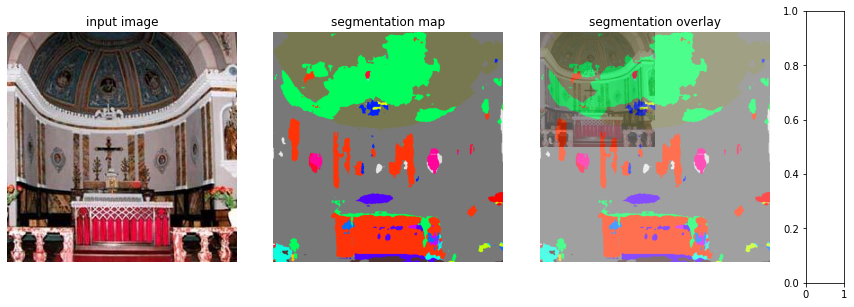

In [69]:
image = Image.open('Datasets/ADE20K_2021_17_01/images/ADE/validation/cultural/apse__indoor/ADE_val_00000025.jpg')
vis_segmentation(image, seg_map)

In [67]:
raw_prediction

array([[[[-2.2410378 ,  7.5312395 ,  1.8121266 , ..., -0.77205545,
          -1.0651278 , -0.538963  ],
         [-2.2359595 ,  7.9712644 ,  1.734469  , ..., -0.8055942 ,
          -1.102687  , -0.37454897],
         [-2.230881  ,  8.411289  ,  1.6568115 , ..., -0.839133  ,
          -1.1402462 , -0.21013494],
         ...,
         [-1.7558367 ,  7.7276053 ,  1.006773  , ...,  0.05742073,
           0.70301074,  0.9335689 ],
         [-1.8173068 ,  7.455063  ,  1.1210376 , ..., -0.13534784,
           0.66725016,  0.88416004],
         [-1.8787769 ,  7.182521  ,  1.2353022 , ..., -0.32811642,
           0.63148963,  0.8347511 ]],

        [[-2.1976597 ,  8.044478  ,  1.5347177 , ..., -0.8690746 ,
          -1.0599437 , -0.38597542],
         [-2.1890898 ,  8.554833  ,  1.529216  , ..., -0.90729505,
          -1.1089557 , -0.3230241 ],
         [-2.18052   ,  9.065189  ,  1.5237143 , ..., -0.94551545,
          -1.1579678 , -0.2600728 ],
         ...,
         [-1.7468967 ,  8.231322  

In [74]:
len([
      [0, 0, 0],
      [120, 120, 120],
      [180, 120, 120],
      [6, 230, 230],
      [80, 50, 50],
      [4, 200, 3],
      [120, 120, 80],
      [140, 140, 140],
      [204, 5, 255],
      [230, 230, 230],
      [4, 250, 7],
      [224, 5, 255],
      [235, 255, 7],
      [150, 5, 61],
      [120, 120, 70],
      [8, 255, 51],
      [255, 6, 82],
      [143, 255, 140],
      [204, 255, 4],
      [255, 51, 7],
      [204, 70, 3],
      [0, 102, 200],
      [61, 230, 250],
      [255, 6, 51],
      [11, 102, 255],
      [255, 7, 71],
      [255, 9, 224],
      [9, 7, 230],
      [220, 220, 220],
      [255, 9, 92],
      [112, 9, 255],
      [8, 255, 214],
      [7, 255, 224],
      [255, 184, 6],
      [10, 255, 71],
      [255, 41, 10],
      [7, 255, 255],
      [224, 255, 8],
      [102, 8, 255],
      [255, 61, 6],
      [255, 194, 7],
      [255, 122, 8],
      [0, 255, 20],
      [255, 8, 41],
      [255, 5, 153],
      [6, 51, 255],
      [235, 12, 255],
      [160, 150, 20],
      [0, 163, 255],
      [140, 140, 140],
      [250, 10, 15],
      [20, 255, 0],
      [31, 255, 0],
      [255, 31, 0],
      [255, 224, 0],
      [153, 255, 0],
      [0, 0, 255],
      [255, 71, 0],
      [0, 235, 255],
      [0, 173, 255],
      [31, 0, 255],
      [11, 200, 200],
      [255, 82, 0],
      [0, 255, 245],
      [0, 61, 255],
      [0, 255, 112],
      [0, 255, 133],
      [255, 0, 0],
      [255, 163, 0],
      [255, 102, 0],
      [194, 255, 0],
      [0, 143, 255],
      [51, 255, 0],
      [0, 82, 255],
      [0, 255, 41],
      [0, 255, 173],
      [10, 0, 255],
      [173, 255, 0],
      [0, 255, 153],
      [255, 92, 0],
      [255, 0, 255],
      [255, 0, 245],
      [255, 0, 102],
      [255, 173, 0],
      [255, 0, 20],
      [255, 184, 184],
      [0, 31, 255],
      [0, 255, 61],
      [0, 71, 255],
      [255, 0, 204],
      [0, 255, 194],
      [0, 255, 82],
      [0, 10, 255],
      [0, 112, 255],
      [51, 0, 255],
      [0, 194, 255],
      [0, 122, 255],
      [0, 255, 163],
      [255, 153, 0],
      [0, 255, 10],
      [255, 112, 0],
      [143, 255, 0],
      [82, 0, 255],
      [163, 255, 0],
      [255, 235, 0],
      [8, 184, 170],
      [133, 0, 255],
      [0, 255, 92],
      [184, 0, 255],
      [255, 0, 31],
      [0, 184, 255],
      [0, 214, 255],
      [255, 0, 112],
      [92, 255, 0],
      [0, 224, 255],
      [112, 224, 255],
      [70, 184, 160],
      [163, 0, 255],
      [153, 0, 255],
      [71, 255, 0],
      [255, 0, 163],
      [255, 204, 0],
      [255, 0, 143],
      [0, 255, 235],
      [133, 255, 0],
      [255, 0, 235],
      [245, 0, 255],
      [255, 0, 122],
      [255, 245, 0],
      [10, 190, 212],
      [214, 255, 0],
      [0, 204, 255],
      [20, 0, 255],
      [255, 255, 0],
      [0, 153, 255],
      [0, 41, 255],
      [0, 255, 204],
      [41, 0, 255],
      [41, 255, 0],
      [173, 0, 255],
      [0, 245, 255],
      [71, 0, 255],
      [122, 0, 255],
      [0, 255, 184],
      [0, 92, 255],
      [184, 255, 0],
      [0, 133, 255],
      [255, 214, 0],
      [25, 194, 194],
      [102, 255, 0],
      [92, 0, 255],
  ])

151

In [76]:
import pickle as pkl
DATASET_PATH = 'Datasets/ADE20K_2021_17_01'
index_file = 'index_ade20k.pkl'
with open('{}/{}'.format(DATASET_PATH, index_file), 'rb') as f:
    index_ade20k = pkl.load(f)

In [90]:
len(set(index_ade20k['objectnames']))

3688